<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/36_3_RNN_%2B_Seq_to_Seq_%D0%BF%D0%B5%D1%80%D0%B5%D0%B2%D0%BE%D0%B4%D1%87%D0%B8%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from random import randint
import pandas as pd
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, LSTM, Input
from keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

In [2]:
!unzip -qo por-eng.zip -d ./data

In [3]:
os.listdir("./data")

['por.txt', '_about.txt']

In [53]:
BATCH_SIZE = 256       # размер обучающего пакета.
EPOCHS = 25          # число эпох обучения.
LATENT_DIM = 256      # размерность латентного или контексного вектора.
NUM_SAMPLES = 50000   # число примеров для обучения.
FILE_NAME = "data/por.txt" # имя файла со словарем в архиве
SOS = '< START >'     # токен начала последовательсти
EOS = '< END >'       # токен окончания последовательсти

In [5]:
df = pd.read_csv(FILE_NAME, sep='\t', header=None)

In [6]:
print(df.head(3))

     0     1                                                  2
0  Go.  Vai.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1  Go.   Vá.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2  Hi.   Oi.  CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [8]:
print(df.tail(1))

                                                        0  \
193632  Using high heat settings while ironing synthet...   

                                                        1  \
193632  A utilização de níveis elevados de calor ao pa...   

                                                        2  
193632  CC-BY 2.0 (France) Attribution: tatoeba.org #3...  


In [42]:
train_questions, train_answers = [], []
test_questions, test_answers = [], []

with open(FILE_NAME, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = SOS + target_text + EOS
    train_questions.append(input_text)
    train_answers.append(target_text)

# расщепляем выборку
print("Размер корпуса:", len(train_questions), '\n')

test_questions = train_questions[45000:]
train_questions = train_questions[:45000]

test_answers = train_answers[45000:]
train_answers = train_answers[:45000]

print("Число обучающих примеров:", len(train_questions))
print("Число тестовых примеров:", len(test_questions), '\n')

# получим случайный вопрос и ответ обучающих примеров
random_index = randint(0, len(train_questions)-1)
print(f'Случайный тестовый вопрос: {train_questions[random_index]}')
print(f'Случайный тестовый вопрос ответ : {train_answers[random_index]}', '\n')

random_index = randint(0, len(test_questions)-1)
print(f'Случайный тестовый вопрос: {test_questions[random_index]}')
print(f'Случайный тестовый вопрос ответ : {test_answers[random_index]}', '\n')

Размер корпуса: 50000 

Число обучающих примеров: 45000
Число тестовых примеров: 5000 

Случайный тестовый вопрос: Run.
Случайный тестовый вопрос ответ : < START >Corre!< END > 

Случайный тестовый вопрос: I've fixed everything.
Случайный тестовый вопрос ответ : < START >Eu tenho consertado tudo.< END > 



In [47]:
# Создадим токенайзер
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n', split=' ')

# Загружаем в токенизатор список фраз вопросов и ответов для сборки словаря частотности
tokenizer.fit_on_texts(train_questions + train_answers)

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())

# Размер словаря
vocabularySize = len(vocabularyItems)+1

# Векторизируем входные и выходные фразы (вопросы и ответы)
tokenizedQuestions = tokenizer.texts_to_sequences(train_questions)
tokenizedAnswers = tokenizer.texts_to_sequences(train_answers)

# Получаем длину самой длинной фразы
maxLenQuestions = max([len(x) for x in tokenizedQuestions])
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы (отдельно для вопросов и ответов)
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Создаем numpy массив для входа в кодировщик
encoderForInput = np.array(paddedQuestions)

# Создаем numpy массив для входа в декодировщик
decoderForInput = np.array(paddedAnswers)

#  Получим случайный вопрос и ответ
random_index = randint(0, len(train_questions)-1)

# Выведем фрагмент и размер словаря
print( f'Фрагмент словаря : {vocabularyItems[:50]}')
print( f'Размер словаря   : {vocabularySize}', '\n')

# Примеры данных для вопросов
print(f'Пример вопроса                         : {train_questions[random_index]}')
print(f'Пример векторизации вопроса            : {encoderForInput[random_index]}')
print(f'Размер векторизованного вопроса        : {encoderForInput.shape}')
print(f'Новая длина вопроса                    : {maxLenQuestions}')

Фрагмент словаря : [('start', 1), ('end', 2), ('tom', 3), ('i', 4), ('eu', 5), ('a', 6), ('é', 7), ('o', 8), ('não', 9), ('is', 10), ('you', 11), ('você', 12), ('de', 13), ('está', 14), ('the', 15), ("i'm", 16), ('que', 17), ('um', 18), ('tom.', 19), ('me', 20), ('to', 21), ('do', 22), ('estou', 23), ('was', 24), ('we', 25), ('my', 26), ('it', 27), ('this', 28), ('are', 29), ('ele', 30), ('nós', 31), ('have', 32), ("don't", 33), ("it's", 34), ("you're", 35), ('uma', 36), ('isso', 37), ('he', 38), ('sou', 39), ('your', 40), ('com', 41), ('like', 42), ('they', 43), ('not', 44), ('por', 45), ('muito', 46), ('you.', 47), ('para', 48), ('me.', 49), ('that', 50)]
Размер словаря   : 22241 

Пример вопроса                         : Help Tom out.
Пример векторизации вопроса            : [176   3 245   0   0   0   0]
Размер векторизованного вопроса        : (45000, 7)
Новая длина вопроса                    : 7


In [48]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(train_answers)

# Избавляемся от тега SOS
for i in range(len(tokenizedAnswers)) :
    tokenizedAnswers[i] = tokenizedAnswers[i][1:]

# Делаем ответы одной длины
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

# Сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)

# Примеры данных для ответов на выходе декодировщика
print(f'Пример выходных данных декодировщика                : {train_answers[random_index]}')
print(f'Пример векторизации выходных данных декодировщика   : {decoderForOutput[random_index]}')
print(f'Размер выходных данных декодировщика                : {decoderForOutput.shape}')
print(f'Новая длина выходных данных декодировщика           : {maxLenAnswers}')

Пример выходных данных декодировщика                : < START >Ajuda o Tom.< END >
Пример векторизации выходных данных декодировщика   : [1152    8   19    2    0    0    0    0    0    0    0    0    0    0]
Размер выходных данных декодировщика                : (45000, 14)
Новая длина выходных данных декодировщика           : 14


In [49]:
# Кодировщик
encoderInputs = Input(shape=(None , ))                                                    # добавим входной слой
encoderEmbedding = Embedding(vocabularySize, LATENT_DIM , mask_zero=True)(encoderInputs)  # добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(LATENT_DIM, return_state=True)(encoderEmbedding) # добавим LSTM
encoderStates = [state_h, state_c]                                                        # соберем контекстный вектор

In [50]:
# Декодировщик
decoderInputs = Input(shape=(None, ))                                                       # добавим входной слой
decoderEmbedding = Embedding(vocabularySize, LATENT_DIM, mask_zero=True) (decoderInputs)    # добавим эмбеддинг
decoderLSTM = LSTM(LATENT_DIM, return_state=True, return_sequences=True)                    # добавим LSTM слой
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)         # погоним выход embedding через LSTM (вектора состояний нас уже не интересуют)
decoderDense = Dense(vocabularySize, activation='softmax')                                  # создадим dense слой с функцией активации softmax и длиной словаря, созданного токенизатором
output = decoderDense (decoderOutputs)                                                      # прогоним  выход LSTM через dense слой

In [51]:
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      5,693,696 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      5,693,696 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        525,312 │ embedding[0][0],       │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 22241)    │      5,715,937 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,153,953 (69.25 MB)

 Trainable params: 18,153,953 (69.25 MB)

 Non-trainable params: 0 (0.00 B)

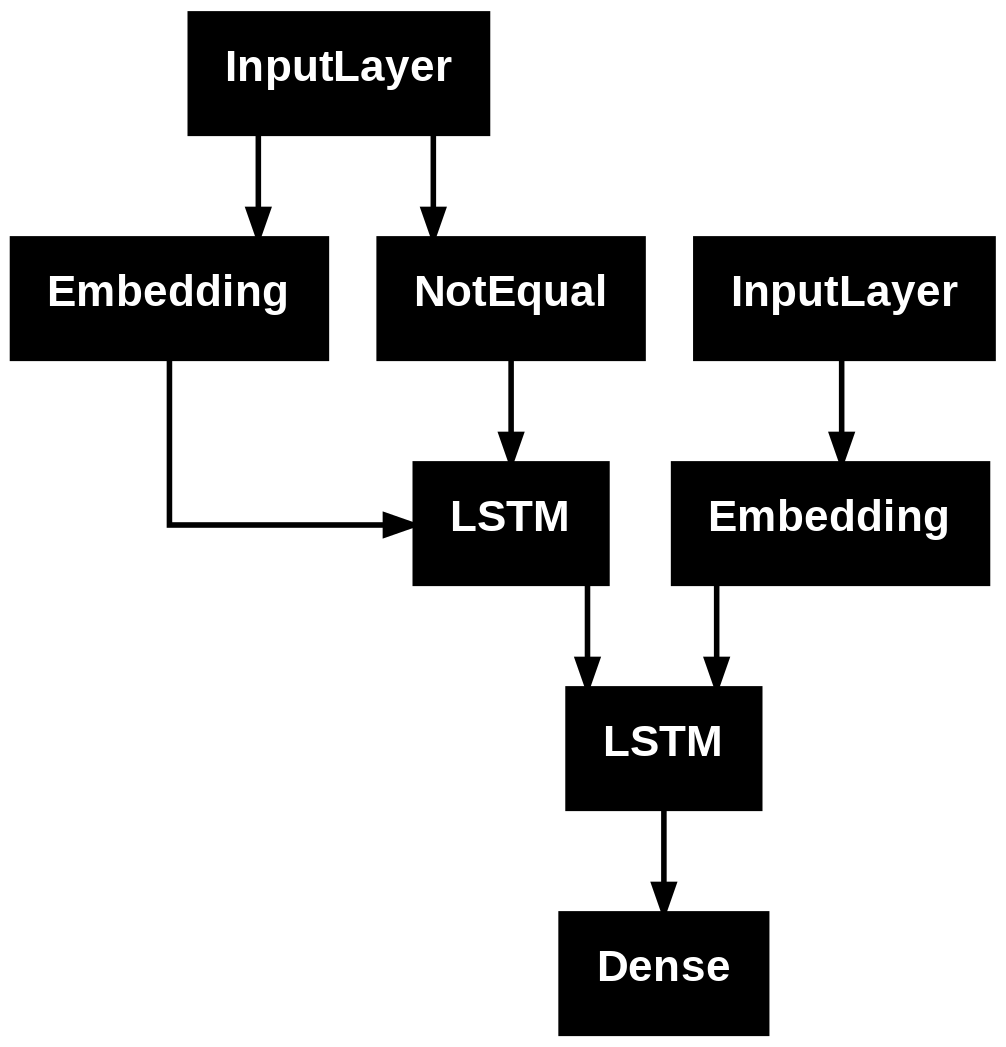

In [52]:
plot_model(model)

In [54]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - loss: 6.9366
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - loss: 4.3846
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 4.2150
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - loss: 4.0308
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 3.8274
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 3.6408
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - loss: 3.4652
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 3.3129
Epoch 9/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - loss: 3.1827
Epoch 10/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 3.0628
Epoch 11/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 2.9508
Epoch 12/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 2.8561
Epoch 13/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 2.7495
Epoch 14/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 2.6725
Epoch 15/25
176

In [55]:
# Создадим модель кодировщика
# На входе будут закодированные вопросы, на выходе состояния state_h, state_c
encoderModel = Model(encoderInputs, encoderStates)
# Создадим модель декодировщика
decoderStateInput_h = Input(shape=(LATENT_DIM,)) # входной слой для state_h
decoderStateInput_c = Input(shape=(LATENT_DIM,)) # входной слой для state_c
# Соберем оба входа вместе
decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
# Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
# LSTM даст нам новые состояния
decoderStates = [state_h, state_c]
# И ответы, которые мы пропустим через полносвязный слой с софтмаксом
decoderOutputs = decoderDense(decoderOutputs)
# Определим модель декодировщика
decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

In [81]:
# создаю датафрейм для табличного вывода
data = {
    'Английская фраза': [],
    'Португальский перевод': [],
    'Предсказанный перевод': [],
    }

df = pd.DataFrame(data)

In [84]:
for i in range(10):

    # три строчки для заполнения датафрейма и подачи вопроса в переводчик
    random_index = randint(0, len(test_questions)-1)
    my_question = test_questions[random_index]
    my_answer = test_answers[random_index]

    words = my_question.lower().split()
    tokens_list = list()
    for word in words:
      try:
          tokens_list.append(tokenizer.word_index[word])
      except:
          pass

    question_token = pad_sequences([tokens_list], maxlen=maxLenQuestions , padding='post')

    targetSeq = np.zeros((1, 1))                        # объявляем последовательность
    targetSeq[0, 0] = tokenizer.word_index['start']     # на начальном этапе последовательность содержит только токен начала последовательности
    stop = False                                        # признак окончания генерации последоватнльности токенов
    decoded_answer = ''                                 # строка с результатом предсказания
    statesValues = encoderModel.predict(question_token) # получение контектного вектора из кодировщика

    while not stop:
        decOutputs , h , c = decoderModel.predict([targetSeq] + statesValues)
        predictIndex = np.argmax( decOutputs[0, 0, :])
        predictWord = None

        for word, index in tokenizer.word_index.items():
            if predictIndex == index:
                decoded_answer += f' {word}'
                predictWord = word

        if predictWord == 'end' or len(decoded_answer.split()) > maxLenAnswers:
            stop = True # устанавливаем признак окончания генерации

        targetSeq = np.zeros((1, 1))
        targetSeq[0, 0] = predictIndex
        statesValues = [h, c]

    # добавляю в таблицу данные
    df.loc[i] = [my_question, my_answer[9:-7], decoded_answer.replace(' end', '')]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [85]:
df

,Английская фраза,Португальский перевод,Предсказанный перевод
0,I've become a new man.,Me tornei um novo homem.,eu tenho um livro.
1,I like to be prepared.,Eu gosto de estar preparada.,eu gosto de ficar bem.
2,I have to make a call.,Tenho que dar um telefonema.,tenho que ir uma vez.
3,Tom looks very happy.,Tom aparenta estar muito feliz.,tom parece muito cansado.
4,"Wait in line, please.","Espere na fila, por favor.",fale com você.
5,Do you believe in God?,Você acredita em Deus?,você vai em nós.
6,Do you have some milk?,Você tem um pouco de leite?,você tem um pouco?
7,I don't even know Tom.,Eu nem sequer conheço Tom.,eu não sei o que ele estava com casa.
8,How can I contact you?,Como posso contatá-lo?,como posso te ajudar?
9,Does Tom speak French?,O Tom fala francês?,o tom sabe que eu fazer?
